In [ ]:
Combined latent representation of normal and tumor data**

In [3]:
import scanpy as sc

# Load the AnnData file correctly
combined_data = sc.read("C:/Users/kshit/Downloads/combined_scVI.h5ad")


C:\Users\kshit\AppData\Roaming\Python\Python312\site-packages\anndata\_core\anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [42]:
combined_data.head()

AttributeError: 'AnnData' object has no attribute 'head'

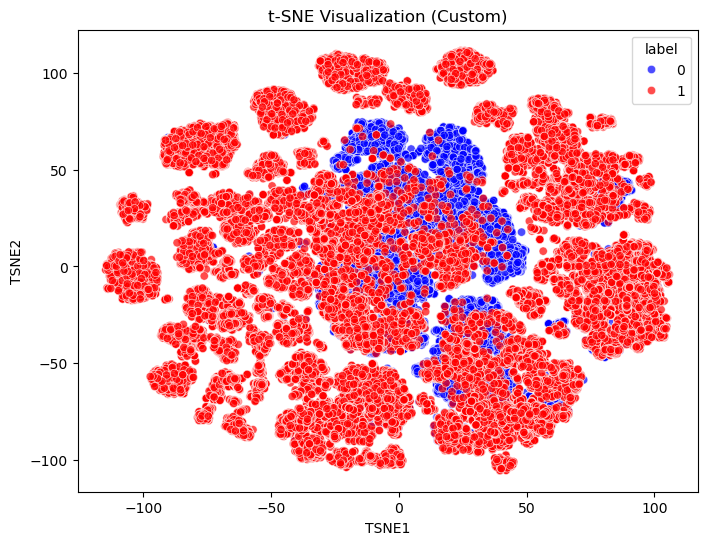

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Convert AnnData latent representation to Pandas DataFrame
df_latent = pd.DataFrame(combined_data.obsm["X_scVI"], columns=[f"scVI_{i}" for i in range(combined_data.obsm["X_scVI"].shape[1])])
df_latent["label"] = combined_data.obs["batch"].values  # Add batch labels

# Extract only numerical features (excluding label)
X = df_latent.drop(columns=["label"]).values
labels = df_latent["label"].values

# Apply t-SNE (2D)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X)

# Convert to DataFrame
df_tsne = pd.DataFrame(X_tsne, columns=["TSNE1", "TSNE2"])
df_tsne["label"] = labels  # Add batch labels for coloring

# Plot t-SNE results using seaborn
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_tsne, x="TSNE1", y="TSNE2", hue="label", alpha=0.7, palette=["blue", "red"])
plt.title("t-SNE Visualization (Custom)")
plt.show()


C:\Users\kshit\AppData\Roaming\Python\Python312\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


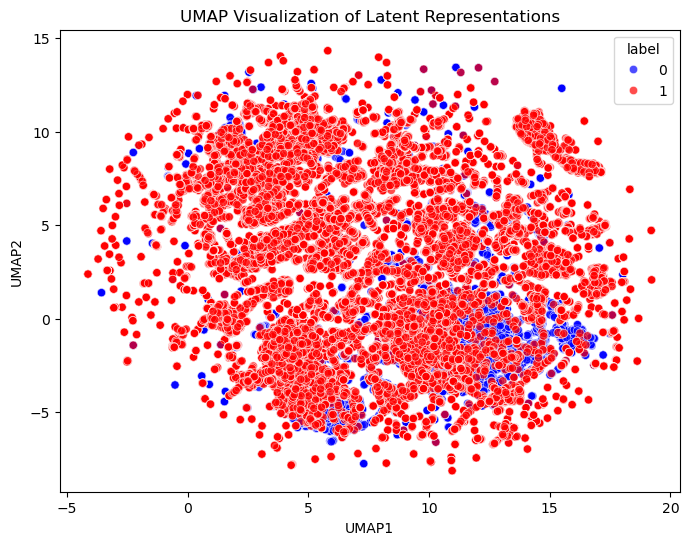

In [5]:
import umap
umap_reducer = umap.UMAP(
    n_neighbors=3,   # Slightly larger neighborhood for smoother clustering
    min_dist=0.01,     # Closer packing of points within clusters
    metric="correlation",
    random_state=42
)



X_umap = umap_reducer.fit_transform(X)



# Convert to DataFrame
df_umap = pd.DataFrame(X_umap, columns=["UMAP1", "UMAP2"])
df_umap["label"] = labels

# Plot
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_umap, x="UMAP1", y="UMAP2", hue="label", alpha=0.7, palette=["blue", "red"])
plt.title("UMAP Visualization of Latent Representations")
plt.show()

C:\Users\kshit\AppData\Roaming\Python\Python312\site-packages\anndata\_core\anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


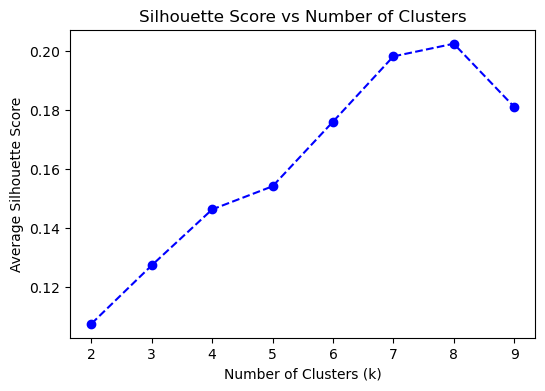

Optimal k based on Silhouette Score: 8


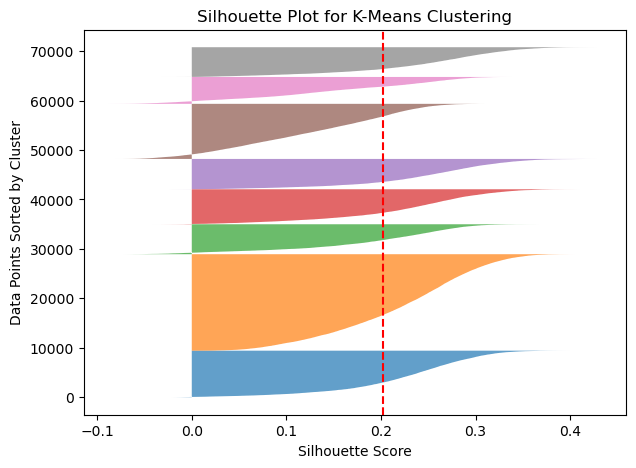

C:\Users\kshit\AppData\Roaming\Python\Python312\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


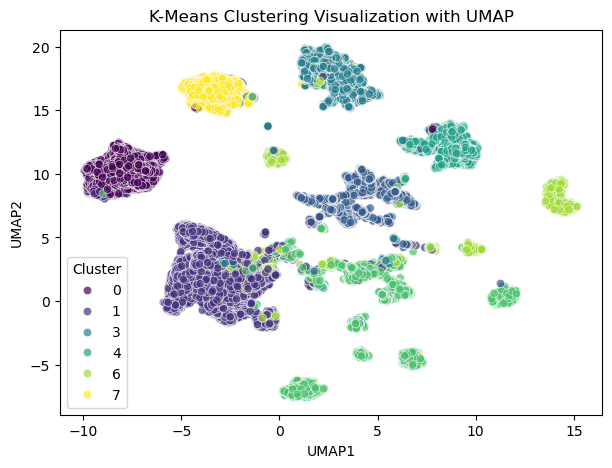

DBSCAN identified 68 clusters


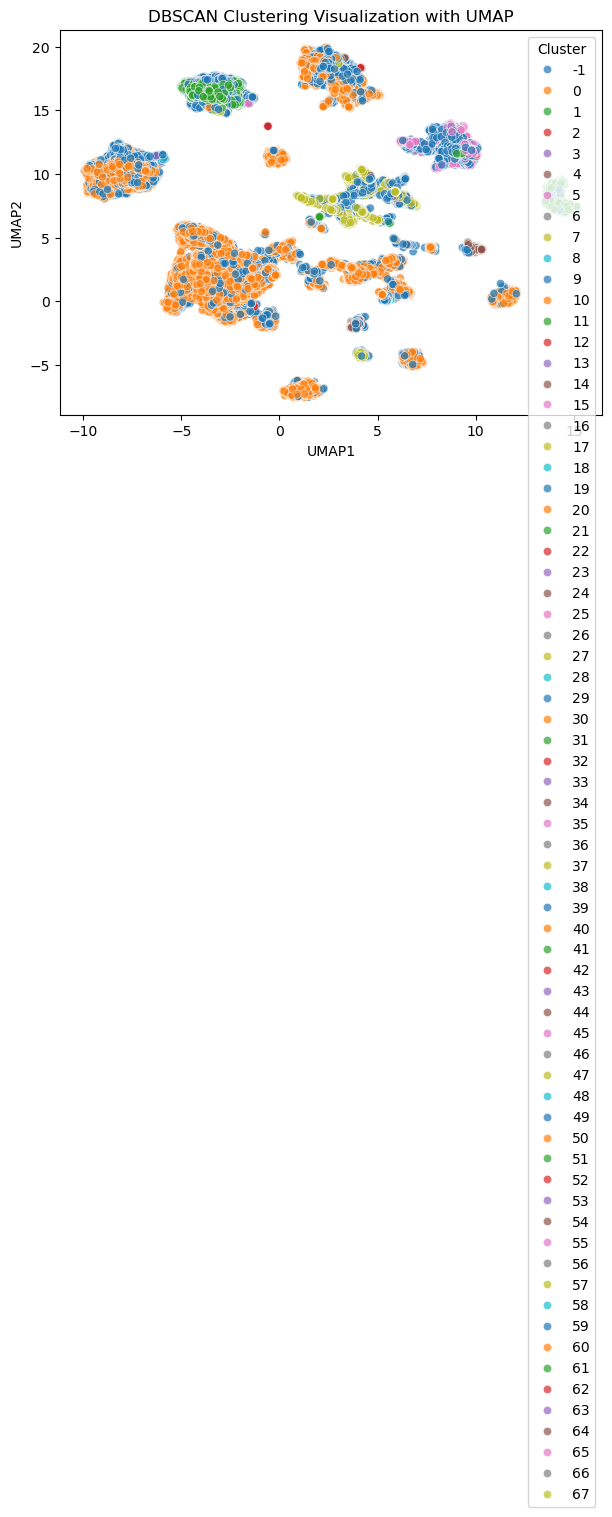

In [6]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from umap import UMAP

# Load the AnnData file correctly
combined_data = sc.read("C:/Users/kshit/Downloads/combined_scVI.h5ad")

# Convert AnnData latent representation to Pandas DataFrame
df_latent = pd.DataFrame(combined_data.obsm["X_scVI"], columns=[f"scVI_{i}" for i in range(combined_data.obsm["X_scVI"].shape[1])])
df_latent["label"] = combined_data.obs["batch"].values  # Add batch labels

# Extract only numerical features (excluding label)
X = df_latent.drop(columns=["label"]).values
labels = df_latent["label"].values

# Standardize Features (important for clustering)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-MEANS CLUSTERING #

# Finding optimal k using Silhouette Score
silhouette_scores = []
k_range = range(2, 10)  # Checking clusters from k=2 to k=9

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot Silhouette Scores
plt.figure(figsize=(6, 4))
plt.plot(k_range, silhouette_scores, marker="o", linestyle="--", color='b')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Average Silhouette Score")
plt.title("Silhouette Score vs Number of Clusters")
plt.show()

# Choose the k with the highest silhouette score
optimal_k = k_range[silhouette_scores.index(max(silhouette_scores))]
print(f"Optimal k based on Silhouette Score: {optimal_k}")

# Apply K-Means with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_latent["KMeans_Cluster"] = kmeans.fit_predict(X_scaled)  # Use df_latent here

# Compute silhouette samples for individual data points
silhouette_vals = silhouette_samples(X_scaled, df_latent["KMeans_Cluster"]) # Use df_latent here

# Plot Silhouette Analysis
plt.figure(figsize=(7, 5))
y_lower, y_upper = 0, 0
for i in range(optimal_k):
    cluster_silhouette_vals = silhouette_vals[df_latent["KMeans_Cluster"] == i] # Use df_latent here
    cluster_silhouette_vals.sort()
    y_upper += len(cluster_silhouette_vals)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals, alpha=0.7)
    y_lower = y_upper

plt.axvline(x=np.mean(silhouette_vals), color="red", linestyle="--")
plt.xlabel("Silhouette Score")
plt.ylabel("Data Points Sorted by Cluster")
plt.title("Silhouette Plot for K-Means Clustering")
plt.show()

# Visualizing K-Means using UMAP
umap_model = UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_scaled)

plt.figure(figsize=(7, 5))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=df_latent["KMeans_Cluster"], palette="viridis", alpha=0.7) # Use df_latent here
plt.title("K-Means Clustering Visualization with UMAP")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend(title="Cluster")
plt.show()

# DBSCAN CLUSTERING #

# Apply DBSCAN
dbscan = DBSCAN(eps=1.0, min_samples=10)  # Adjust eps and min_samples as needed
df_latent["DBSCAN_Cluster"] = dbscan.fit_predict(X_scaled) # Use df_latent here

# Count number of clusters (excluding noise, labeled as -1)
n_clusters_dbscan = len(set(df_latent["DBSCAN_Cluster"])) - (1 if -1 in df_latent["DBSCAN_Cluster"].values else 0) # Use df_latent here
print(f"DBSCAN identified {n_clusters_dbscan} clusters")

# Visualizing DBSCAN using UMAP
plt.figure(figsize=(7, 5))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=df_latent["DBSCAN_Cluster"], palette="tab10", alpha=0.7) # Use df_latent here
plt.title("DBSCAN Clustering Visualization with UMAP")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend(title="Cluster")
plt.show()

In [7]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=optimal_k, random_state=42)
df_latent["GMM_Cluster"] = gmm.fit_predict(X_scaled)


In [8]:
n_clusters_gmm = len(set(df_latent["GMM_Cluster"]))
print(f"Gaussian Mixture Model identified {n_clusters_gmm} clusters")


Gaussian Mixture Model identified 8 clusters


In [9]:
from sklearn.metrics import silhouette_score

silhouette_gmm = silhouette_score(X_scaled, df_latent["GMM_Cluster"])
print(f"Silhouette Score for GMM Clustering: {silhouette_gmm:.4f}")


Silhouette Score for GMM Clustering: 0.1994


C:\Users\kshit\AppData\Roaming\Python\Python312\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


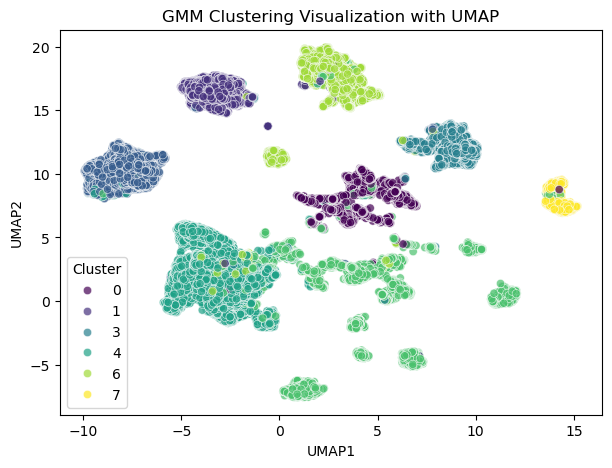

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import umap.umap_ as umap

# Run UMAP for 2D visualization
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_scaled)

# Create a scatter plot for GMM clusters
plt.figure(figsize=(7, 5))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=df_latent["GMM_Cluster"], palette="viridis", alpha=0.7)
plt.title("GMM Clustering Visualization with UMAP")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend(title="Cluster")
plt.show()


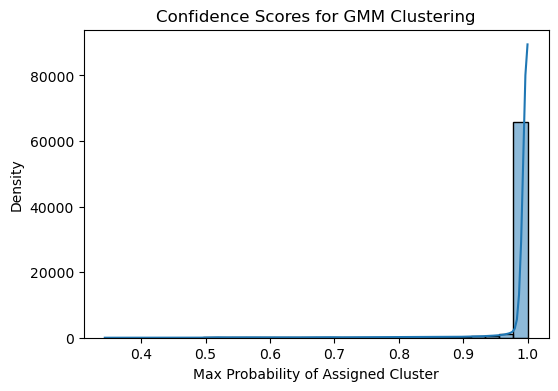

In [11]:
gmm_probs = gmm.predict_proba(X_scaled)
df_latent["GMM_Confidence"] = gmm_probs.max(axis=1)

# Visualize confidence distribution
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.histplot(df_latent["GMM_Confidence"], bins=30, kde=True)
plt.title("Confidence Scores for GMM Clustering")
plt.xlabel("Max Probability of Assigned Cluster")
plt.ylabel("Density")
plt.show()


In [12]:
from sklearn.mixture import GaussianMixture

for k in range(4, 10):  # Try different numbers of clusters
    gmm = GaussianMixture(n_components=k, random_state=42)
    labels = gmm.fit_predict(X_scaled)
    silhouette = silhouette_score(X_scaled, labels)
    print(f"GMM with {k} clusters → Silhouette Score: {silhouette:.4f}")


GMM with 4 clusters → Silhouette Score: 0.1327
GMM with 5 clusters → Silhouette Score: 0.1593
GMM with 6 clusters → Silhouette Score: 0.1704
GMM with 7 clusters → Silhouette Score: 0.1929
GMM with 8 clusters → Silhouette Score: 0.1994
GMM with 9 clusters → Silhouette Score: 0.1597


In [13]:
# Since your GMM is behaving like hard clustering, test K-Means and compare silhouette scores:


from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_latent["KMeans_Cluster"] = kmeans.fit_predict(X_scaled)

# Compare silhouette scores
gmm_silhouette = silhouette_score(X_scaled, df_latent["GMM_Cluster"])
kmeans_silhouette = silhouette_score(X_scaled, df_latent["KMeans_Cluster"])

print(f"GMM Silhouette Score: {gmm_silhouette:.4f}")
print(f"K-Means Silhouette Score: {kmeans_silhouette:.4f}")


GMM Silhouette Score: 0.1994
K-Means Silhouette Score: 0.2045


In [14]:
print(combined_data.obs["batch"].unique())  # Should show "normal" and "tumor"


['0', '1']
Categories (2, object): ['0', '1']


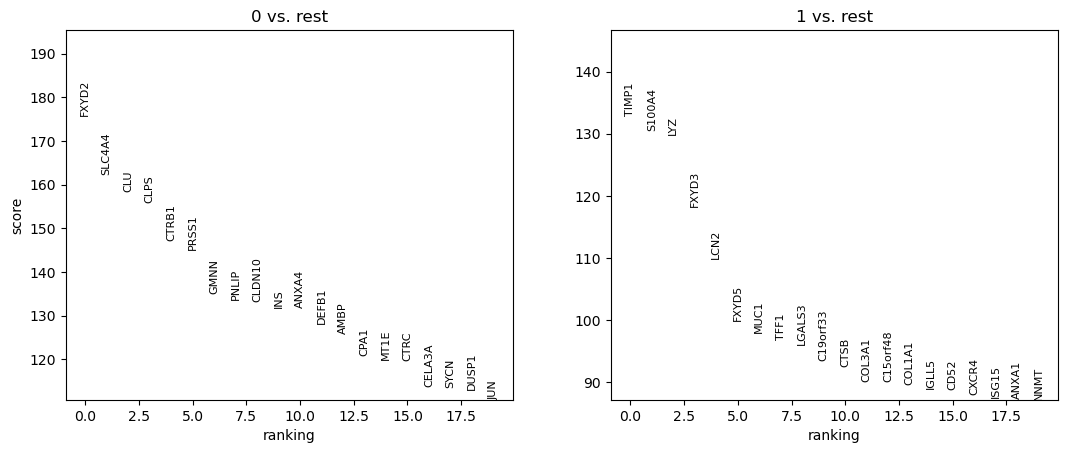

In [15]:
sc.tl.rank_genes_groups(combined_data, groupby="batch", method="wilcoxon")  # or 't-test'
sc.pl.rank_genes_groups(combined_data, n_genes=20, sharey=False)


In [16]:
import pandas as pd
deg_results = pd.DataFrame(combined_data.uns["rank_genes_groups"]["names"])
print(deg_results.head(10))


        0         1
0   FXYD2     TIMP1
1  SLC4A4    S100A4
2     CLU       LYZ
3    CLPS     FXYD3
4   CTRB1      LCN2
5   PRSS1     FXYD5
6    GMNN      MUC1
7   PNLIP      TFF1
8  CLDN10    LGALS3
9     INS  C19orf33


In [17]:
deg_results

,0,1
0,FXYD2,TIMP1
1,SLC4A4,S100A4
2,CLU,LYZ
3,CLPS,FXYD3
4,CTRB1,LCN2
...,...,...
1377,LCN2,CTRB1
1378,FXYD3,CLPS
1379,LYZ,CLU
1380,S100A4,SLC4A4


In [18]:
import pandas as pd

# Extract the groups in your differential expression analysis
groups = list(combined_data.uns["rank_genes_groups"]["names"].dtype.names)

# Create an empty DataFrame
deg_results = pd.DataFrame()

# Loop through each group and extract genes and their statistics
for group in groups:
    df = pd.DataFrame({
        "gene": combined_data.uns["rank_genes_groups"]["names"][group],  
        "log2FC": combined_data.uns["rank_genes_groups"]["logfoldchanges"][group],
        "pval": combined_data.uns["rank_genes_groups"]["pvals"][group],
        "pval_adj": combined_data.uns["rank_genes_groups"]["pvals_adj"][group],
        "score": combined_data.uns["rank_genes_groups"]["scores"][group],
        "group": group  # Add group name for clarity
    })
    deg_results = pd.concat([deg_results, df], ignore_index=True)

# Save to CSV
deg_results.to_csv("deg_results.csv", index=False)

print("DEG results saved successfully!")


DEG results saved successfully!


In [19]:
deg_results


,gene,log2FC,pval,pval_adj,score,group
0,FXYD2,3.546971,0.0,0.0,175.878891,0
1,SLC4A4,3.594701,0.0,0.0,162.253937,0
2,CLU,2.470237,0.0,0.0,158.374176,0
3,CLPS,3.739635,0.0,0.0,155.837143,0
4,CTRB1,3.391443,0.0,0.0,147.244827,0
...,...,...,...,...,...,...
2759,CTRB1,-3.391443,0.0,0.0,-147.244827,1
2760,CLPS,-3.739635,0.0,0.0,-155.837143,1
2761,CLU,-2.470237,0.0,0.0,-158.374176,1
2762,SLC4A4,-3.594701,0.0,0.0,-162.253937,1


In [20]:
print(combined_data.uns["rank_genes_groups"].keys())  # Check available keys
print(combined_data.uns["rank_genes_groups"]["names"])  # Check available groups


dict_keys(['params', 'names', 'scores', 'pvals', 'pvals_adj', 'logfoldchanges'])
[('FXYD2', 'TIMP1') ('SLC4A4', 'S100A4') ('CLU', 'LYZ') ... ('LYZ', 'CLU')
 ('S100A4', 'SLC4A4') ('TIMP1', 'FXYD2')]


In [21]:
# Set thresholds
log2fc_threshold = 1
pval_adj_threshold = 0.05

# Filter significant DEGs
significant_deg = deg_results[
    (deg_results["log2FC"].abs() > log2fc_threshold) & (deg_results["pval_adj"] < pval_adj_threshold)
]

# Save filtered DEGs
significant_deg.to_csv("significant_deg.csv", index=False)

print(f"Significant DEGs: {significant_deg.shape[0]} genes")


Significant DEGs: 1732 genes


C:\ProgramData\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


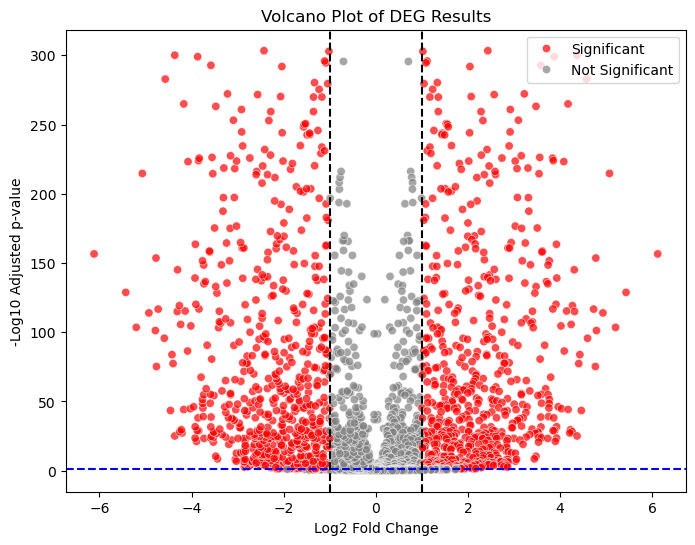

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Add a column for DEG classification
deg_results["DEG"] = np.where(
    (deg_results["log2FC"].abs() > log2fc_threshold) & (deg_results["pval_adj"] < pval_adj_threshold),
    "Significant",
    "Not Significant"
)

# Plot
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=deg_results, x="log2FC", y=-np.log10(deg_results["pval_adj"]),
    hue="DEG", palette={"Significant": "red", "Not Significant": "gray"}, alpha=0.7
)
plt.axhline(-np.log10(pval_adj_threshold), linestyle="--", color="blue")  # p-value cutoff
plt.axvline(-log2fc_threshold, linestyle="--", color="black")  # log2FC cutoff (negative)
plt.axvline(log2fc_threshold, linestyle="--", color="black")  # log2FC cutoff (positive)
plt.xlabel("Log2 Fold Change")
plt.ylabel("-Log10 Adjusted p-value")
plt.title("Volcano Plot of DEG Results")
plt.legend()
plt.show()


In [23]:
pip install gseapy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [24]:
import gseapy as gp

# Extract significant gene names
gene_list = significant_deg["gene"].tolist()

# Perform KEGG pathway analysis
enr = gp.enrichr(gene_list=gene_list, gene_sets="KEGG_2021_Human", organism="human")

# Save results
enr.results.to_csv("kegg_enrichment.csv", index=False)

# Show top pathways
print(enr.results.head(10))


          Gene_set                                               Term Overlap  \
0  KEGG_2021_Human                    Staphylococcus aureus infection   34/95   
1  KEGG_2021_Human                         Hematopoietic cell lineage   33/99   
2  KEGG_2021_Human                   Protein digestion and absorption  31/103   
3  KEGG_2021_Human                                          Phagosome  36/152   
4  KEGG_2021_Human                                      Leishmaniasis   26/77   
5  KEGG_2021_Human                               Rheumatoid arthritis   28/93   
6  KEGG_2021_Human             Cytokine-cytokine receptor interaction  49/295   
7  KEGG_2021_Human       Intestinal immune network for IgA production   20/48   
8  KEGG_2021_Human                                            Malaria   20/50   
9  KEGG_2021_Human  Viral protein interaction with cytokine and cy...  26/100   

        P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0  1.289756e-22      3.456547e-20   

In [25]:
enr.results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268 entries, 0 to 267
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Gene_set              268 non-null    object 
 1   Term                  268 non-null    object 
 2   Overlap               268 non-null    object 
 3   P-value               268 non-null    float64
 4   Adjusted P-value      268 non-null    float64
 5   Old P-value           268 non-null    int64  
 6   Old Adjusted P-value  268 non-null    int64  
 7   Odds Ratio            268 non-null    float64
 8   Combined Score        268 non-null    float64
 9   Genes                 268 non-null    object 
dtypes: float64(4), int64(2), object(4)
memory usage: 21.1+ KB


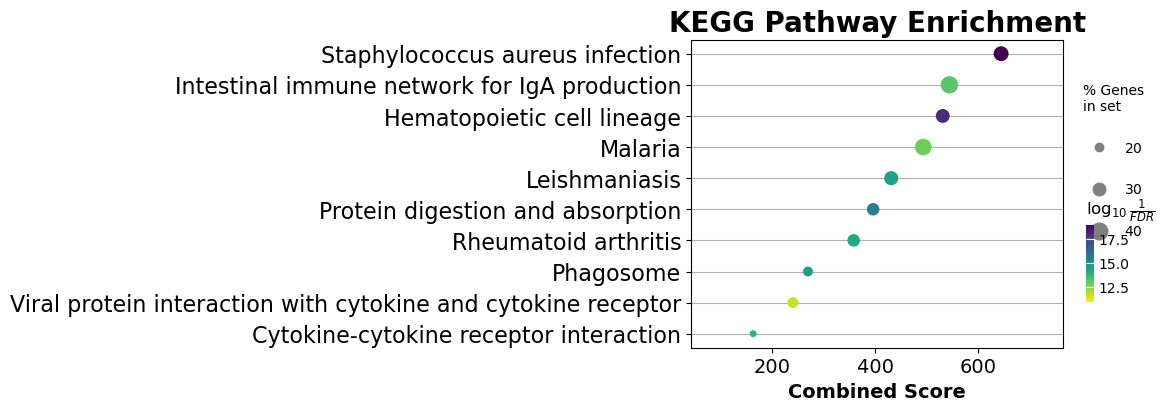

In [26]:
import gseapy as gp
import matplotlib.pyplot as plt

# Create a dot plot for the enriched pathways
gp.dotplot(enr.results, column="Adjusted P-value", title="KEGG Pathway Enrichment", figsize=(6, 4))

# Show the plot
plt.show()


In [27]:
import gseapy as gp

# Perform GO enrichment analysis
go_results = gp.enrichr(
    gene_list=gene_list,  # List of significant DEGs
    gene_sets=["GO_Biological_Process_2021", "GO_Molecular_Function_2021", "GO_Cellular_Component_2021"],
    organism="human"
)

# Save GO results
go_results.results.to_csv("go_enrichment.csv", index=False)

# Print the top GO terms
print(go_results.results.head(10))


                     Gene_set  \
0  GO_Biological_Process_2021   
1  GO_Biological_Process_2021   
2  GO_Biological_Process_2021   
3  GO_Biological_Process_2021   
4  GO_Biological_Process_2021   
5  GO_Biological_Process_2021   
6  GO_Biological_Process_2021   
7  GO_Biological_Process_2021   
8  GO_Biological_Process_2021   
9  GO_Biological_Process_2021   

                                                Term  Overlap       P-value  \
0   cytokine-mediated signaling pathway (GO:0019221)  100/621  8.897657e-31   
1     extracellular matrix organization (GO:0030198)   66/300  1.683331e-28   
2                 inflammatory response (GO:0006954)   56/230  1.071686e-26   
3         regulation of immune response (GO:0050776)   48/179  4.875702e-25   
4  cellular response to cytokine stimulus (GO:007...   79/482  6.280738e-25   
5  extracellular structure organization (GO:0043062)   50/216  6.747420e-23   
6  external encapsulating structure organization ...   50/217  8.414324e-23   
7   

In [28]:
import pandas as pd

# Load KEGG and GO results
kegg_df = pd.read_csv("kegg_enrichment.csv")
go_df = pd.read_csv("go_enrichment.csv")

# Filter for significant pathways (adjusted p-value < 0.05)
kegg_df = kegg_df[kegg_df["Adjusted P-value"] < 0.05]
go_df = go_df[go_df["Adjusted P-value"] < 0.05]

# Show top pathways
print("\n🔬 Top KEGG Pathways (Biological Pathways)")
print(kegg_df[["Term", "Adjusted P-value"]].head(10))

print("\n🔬 Top GO Biological Process Terms (Functional Changes)")
print(go_df[["Term", "Adjusted P-value"]].head(10))



🔬 Top KEGG Pathways (Biological Pathways)
                                                Term  Adjusted P-value
0                    Staphylococcus aureus infection      3.456547e-20
1                         Hematopoietic cell lineage      9.645442e-19
2                   Protein digestion and absorption      2.860365e-16
3                                          Phagosome      2.329172e-15
4                                      Leishmaniasis      3.718096e-15
5                               Rheumatoid arthritis      6.074576e-15
6             Cytokine-cytokine receptor interaction      1.604359e-14
7       Intestinal immune network for IgA production      7.693833e-14
8                                            Malaria      1.773996e-13
9  Viral protein interaction with cytokine and cy...      2.167926e-12

🔬 Top GO Biological Process Terms (Functional Changes)
                                                Term  Adjusted P-value
0   cytokine-mediated signaling pathway (GO:00192

In [29]:
print("Expression Matrix Shape:", combined_data.X.shape)  # (cells, genes)
print("Number of Genes:", len(combined_data.var_names))  # Should match second dim of X
print("Number of Cells:", len(combined_data.obs_names))  # Should match first dim of X


Expression Matrix Shape: (70799, 1382)
Number of Genes: 1382
Number of Cells: 70799


In [30]:
import pandas as pd
import scipy.sparse

# Convert sparse matrix to dense (if needed)
if scipy.sparse.issparse(combined_data.X):
    expr_matrix = combined_data.X.toarray()
else:
    expr_matrix = combined_data.X

# Ensure correct shape (genes as rows, cells as columns)
expr_matrix_df = pd.DataFrame(expr_matrix.T, index=combined_data.var_names, columns=combined_data.obs_names)

# Save to CSV
expr_matrix_df.to_csv("C:/Users/kshit/Downloads/expression_matrix.csv")

print("Expression matrix saved successfully!")


Expression matrix saved successfully!


In [31]:
expr_matrix_df

,AAACCTGAGAAGGGTA-1-0,AAACCTGGTTCGCGAC-1-0,AAACGGGGTACAGACG-1-0,AAAGATGAGATGTTAG-1-0,AAAGATGCAATTCCTT-1-0,AAAGATGCAGCCTGTG-1-0,AAAGATGTCCTTTCTC-1-0,AAAGCAAAGAGGACGG-1-0,AAAGCAACAAGCGATG-1-0,AAAGCAACAGCCACCA-1-0,...,TTGTAGGAGCTTATCG-1-23,TTTACTGAGCATCATC-1-23,TTTACTGAGCTGCCCA-1-23,TTTACTGTCAAACCAC-1-23,TTTATGCCACGGATAG-1-23,TTTCCTCCAATGGAGC-1-23,TTTCCTCGTGAAATCA-1-23,TTTGCGCGTTAGATGA-1-23,TTTGCGCTCTGGGCCA-1-23,TTTGGTTAGTATTGGA-1-23
TIE1,0.000000,0.000000,1.363757,0.000000,0.000000,1.786854,1.995684,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.419366,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
LPL,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.419366,0.000000,0.000000,0.000000,0.000000,1.027303,0.000000,0.000000
ANGPT2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.419366,0.000000,0.000000,0.000000,2.188451,0.000000,0.000000,1.468623
CTC-479C5.12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.545749,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
S100A9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.622816,3.178640,1.419366,0.000000,1.718614,0.000000,0.000000,1.350954,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MAF,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.930739,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MT1E,2.051375,1.771551,1.701769,1.902408,2.286767,0.000000,2.284493,1.615060,0.000000,0.000000,...,1.930739,0.000000,2.287860,0.000000,1.718614,2.144621,0.000000,1.741172,0.000000,2.087780
INS,2.381038,2.255745,2.431636,2.377745,2.916147,2.340000,2.790296,2.431897,2.445225,2.462024,...,1.622816,2.356292,1.419366,1.545749,0.000000,1.539253,0.000000,0.000000,2.034907,1.468623
CELF2,0.000000,0.000000,0.000000,0.000000,0.000000,1.786854,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.539253,0.000000,0.000000,0.000000,0.000000


In [32]:
expr_matrix_df.isna().sum().sum()

0

In [33]:
annotation_df = pd.read_csv("C:/Users/kshit/Downloads/SingleR_annotations.csv")

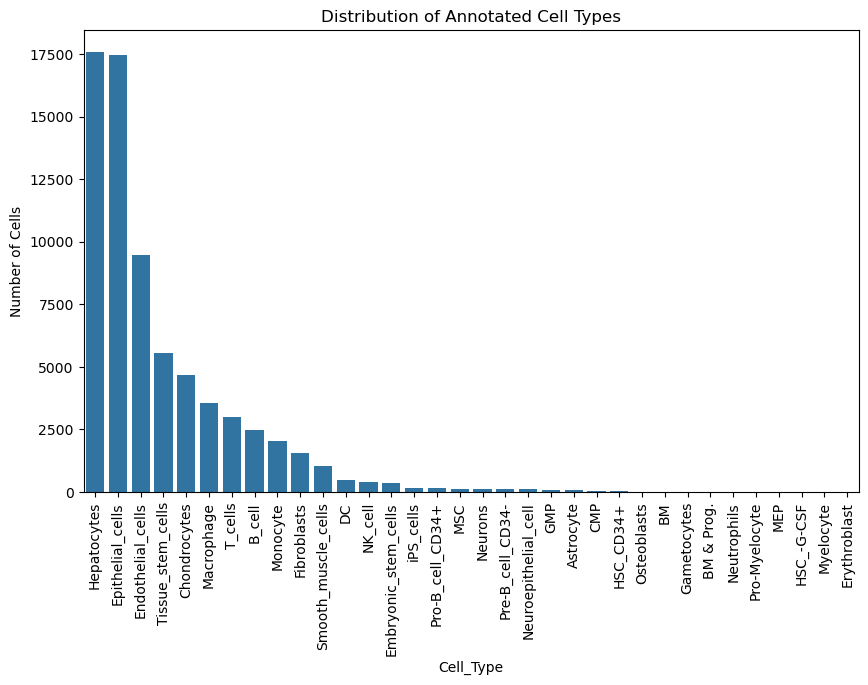

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load SingleR annotations


# Count cell types
cell_counts = annotation_df["Cell_Type"].value_counts()

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x=cell_counts.index, y=cell_counts.values)
plt.xticks(rotation=90)
plt.title("Distribution of Annotated Cell Types")
plt.ylabel("Number of Cells")
plt.show()


In [35]:
import pandas as pd


# Ensure AnnData has tumor/normal labels
tumor_normal_labels = combined_data.obs["batch"].values  

# Add tumor/normal labels to annotations
annotation_df["Sample_Type"] = tumor_normal_labels

# Save updated annotations
annotation_df.to_csv("C:/Users/kshit/Downloads/SingleR_Annotated_with_Tumor_Normal.csv", index=False)

print(annotation_df.head())


                Cell_ID          Cell_Type Sample_Type
0  AAACCTGAGAAGGGTA.1.0        Hepatocytes           0
1  AAACCTGGTTCGCGAC.1.0        Hepatocytes           0
2  AAACGGGGTACAGACG.1.0  Endothelial_cells           0
3  AAAGATGAGATGTTAG.1.0        Hepatocytes           0
4  AAAGATGCAATTCCTT.1.0        Hepatocytes           0


C:\Users\kshit\AppData\Local\Temp\ipykernel_3892\4195799371.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_counts = annotation_df.groupby(["Cell_Type", "Sample_Type"]).size().reset_index(name="Count")


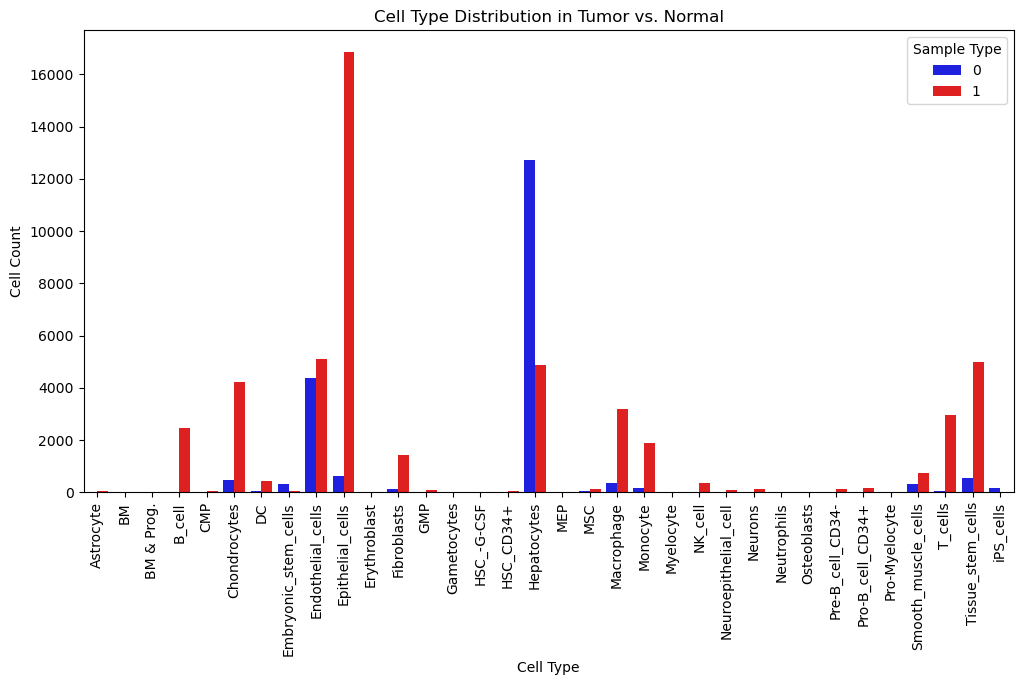

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count occurrences of each cell type in tumor vs. normal
cell_counts = annotation_df.groupby(["Cell_Type", "Sample_Type"]).size().reset_index(name="Count")

# Plot
plt.figure(figsize=(12,6))
sns.barplot(data=cell_counts, x="Cell_Type", y="Count", hue="Sample_Type", palette=["blue", "red"])
plt.xticks(rotation=90)
plt.title("Cell Type Distribution in Tumor vs. Normal")
plt.xlabel("Cell Type")
plt.ylabel("Cell Count")
plt.legend(title="Sample Type")
plt.show()


In [37]:
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = annotation_df.pivot_table(index="Cell_Type", columns="Sample_Type", aggfunc="size", fill_value=0)

# Perform Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square test p-value: {p}")

# If p < 0.05, cell type distribution is significantly different between tumor and normal


Chi-square test p-value: 0.0


C:\Users\kshit\AppData\Local\Temp\ipykernel_3892\3683890563.py:4: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  contingency_table = annotation_df.pivot_table(index="Cell_Type", columns="Sample_Type", aggfunc="size", fill_value=0)


In [38]:
import pandas as pd
from scipy.stats import ranksums

# Ensure 'Sample_Type' is correctly filtered
tumor_cells = annotation_df[annotation_df['Sample_Type'] == 1]['Cell_Type'].value_counts()
normal_cells = annotation_df[annotation_df['Sample_Type'] == 0]['Cell_Type'].value_counts()

# Perform Wilcoxon rank-sum test per cell type
p_values = []
for cell_type in annotation_df['Cell_Type'].unique():
    tumor_counts = annotation_df[(annotation_df['Sample_Type'] == 1) & 
                                 (annotation_df['Cell_Type'] == cell_type)].shape[0]
    
    normal_counts = annotation_df[(annotation_df['Sample_Type'] == 0) & 
                                  (annotation_df['Cell_Type'] == cell_type)].shape[0]

    # Perform Wilcoxon test
    if tumor_counts > 0 and normal_counts > 0:
        _, p = ranksums([tumor_counts], [normal_counts])
        p_values.append((cell_type, p))
    else:
        p_values.append((cell_type, 1.0))  # Assign p=1 for missing categories

# Store results
deg_cell_df = pd.DataFrame(p_values, columns=['Cell_Type', 'P_Value']).sort_values('P_Value')
print(deg_cell_df)


               Cell_Type  P_Value
0            Hepatocytes      1.0
31                   MEP      1.0
30         Pro-Myelocyte      1.0
29           Neutrophils      1.0
28             Myelocyte      1.0
27                    BM      1.0
26      Pre-B_cell_CD34-      1.0
25           Osteoblasts      1.0
24                   MSC      1.0
23            BM & Prog.      1.0
22                   GMP      1.0
21      Pro-B_cell_CD34+      1.0
20                   CMP      1.0
19                B_cell      1.0
18             HSC_CD34+      1.0
17                    DC      1.0
16               T_cells      1.0
15               NK_cell      1.0
1      Endothelial_cells      1.0
2              iPS_cells      1.0
3       Epithelial_cells      1.0
4   Embryonic_stem_cells      1.0
5   Neuroepithelial_cell      1.0
6      Tissue_stem_cells      1.0
32            HSC_-G-CSF      1.0
7           Chondrocytes      1.0
9    Smooth_muscle_cells      1.0
10             Astrocyte      1.0
11           F

C:\Users\kshit\AppData\Local\Temp\ipykernel_3892\2761304386.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_counts = annotation_df.groupby(['Sample_Type', 'Cell_Type']).size().unstack().fillna(0)


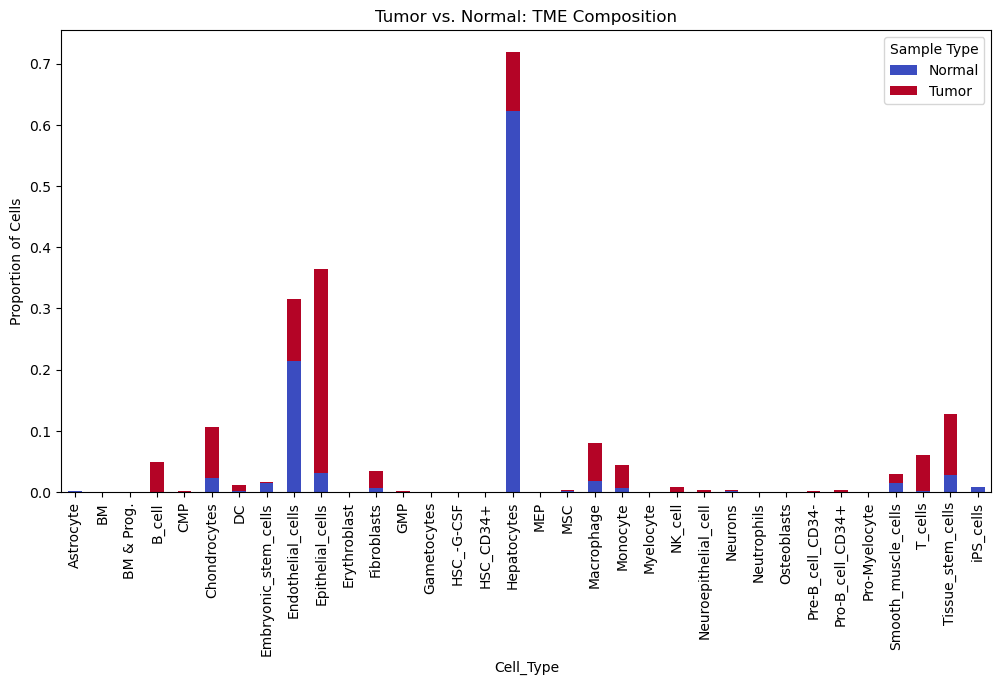

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming `metadata` contains 'Cell_Type' and 'Sample_Type' (0 = Normal, 1 = Tumor)
cell_counts = annotation_df.groupby(['Sample_Type', 'Cell_Type']).size().unstack().fillna(0)

# Normalize to get proportions
cell_proportions = cell_counts.div(cell_counts.sum(axis=1), axis=0)

# Plot stacked bar chart
cell_proportions.T.plot(kind='bar', stacked=True, figsize=(12,6), colormap='coolwarm')
plt.ylabel('Proportion of Cells')
plt.title('Tumor vs. Normal: TME Composition')
plt.legend(title='Sample Type', labels=['Normal', 'Tumor'])
plt.xticks(rotation=90)
plt.show()


**Cell Cell Communication Analysis**

In [45]:
!pip install cellphonedb


Defaulting to user installation because normal site-packages is not writeable


In [41]:
annotation_df.head()

,Cell_ID,Cell_Type,Sample_Type
0,AAACCTGAGAAGGGTA.1.0,Hepatocytes,0
1,AAACCTGGTTCGCGAC.1.0,Hepatocytes,0
2,AAACGGGGTACAGACG.1.0,Endothelial_cells,0
3,AAAGATGAGATGTTAG.1.0,Hepatocytes,0
4,AAAGATGCAATTCCTT.1.0,Hepatocytes,0


In [43]:
import scanpy as sc

# Load the AnnData file
combined_data = sc.read("C:/Users/kshit/Downloads/combined_scVI.h5ad")

# Convert to DataFrame (Genes x Cells)
expression_matrix = combined_data.to_df().T  # Transpose to get genes as rows

# Save as CSV
expression_matrix.to_csv("gene_expression_matrix.csv")

# Display the first few rows
print(expression_matrix.head())


C:\Users\kshit\AppData\Roaming\Python\Python312\site-packages\anndata\_core\anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


              AAACCTGAGAAGGGTA-1-0  AAACCTGGTTCGCGAC-1-0  \
TIE1                           0.0                   0.0   
LPL                            0.0                   0.0   
ANGPT2                         0.0                   0.0   
CTC-479C5.12                   0.0                   0.0   
S100A9                         0.0                   0.0   

              AAACGGGGTACAGACG-1-0  AAAGATGAGATGTTAG-1-0  \
TIE1                      1.363757                   0.0   
LPL                       0.000000                   0.0   
ANGPT2                    0.000000                   0.0   
CTC-479C5.12              0.000000                   0.0   
S100A9                    0.000000                   0.0   

              AAAGATGCAATTCCTT-1-0  AAAGATGCAGCCTGTG-1-0  \
TIE1                           0.0              1.786854   
LPL                            0.0              0.000000   
ANGPT2                         0.0              0.000000   
CTC-479C5.12                   0.0    

In [44]:
expression_matrix.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1382 entries, TIE1 to ALOX15B
Columns: 70799 entries, AAACCTGAGAAGGGTA-1-0 to TTTGGTTAGTATTGGA-1-23
dtypes: float32(70799)
memory usage: 373.3+ MB


In [46]:
!cellphonedb method statistical_analysis annotation_df expression_matrix


'cellphonedb' is not recognized as an internal or external command,
operable program or batch file.


In [48]:
!cellphonedb --version




'cellphonedb' is not recognized as an internal or external command,
operable program or batch file.


In [49]:
pip install cytoTalk


Note: you may need to restart the kernel to use updated packages.Defaulting to user installation because normal site-packages is not writeable



ERROR: Could not find a version that satisfies the requirement cytoTalk (from versions: none)
ERROR: No matching distribution found for cytoTalk


In [50]:
import cytoTalk
# cytoTalk.run("gene_expression_matrix.csv", "metadata.csv")


ModuleNotFoundError: No module named 'cytoTalk'

In [51]:
expression_matrix.to_csv("C:/Users/kshit/Downloads/gene_expression_matrix.csv",index = False)
